In [27]:
## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn import svm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=2)
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,classification_report
import datetime as dt
from mpl_toolkits.basemap import Basemap
from unbalanced_dataset import SMOTE
import os

%matplotlib inline

In [28]:
#In Python: Define a database name (event_db), and your username for your computer. 
dbname = 'event_db'
username = 'elahe'
#to run below commands PostgreSQL should be launched
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%('elahe','event_db'))
print(engine.url)
con = None
con = psycopg2.connect(database = 'event_db', user = 'elahe')

postgres://elahe@localhost/event_db


In [29]:
#change state fips and city fips into longitudental and latitudenal inforamation by averaging 
#for whole city
def linked_lat_lon(flight_df,threshold):
    sql_query ="""
    select *
    from county_fips_lat_lon_table
    """
    county_fips_lat_lon = pd.read_sql_query(sql_query,con)
    flight_df = pd.merge(flight_df,county_fips_lat_lon,on=['fips'],how='left')
    flight_df['ID'] = flight_df.index
   
    flight_df=flight_df.dropna()
    flight_df = flight_df.drop(['city','STATE_FIPS_x','STATE_FIPS_y','STATE_AB'],axis=1)
    flight_df = flight_df.dropna()
    
    #flight_df.to_sql('flight_df_table', engine, if_exists='replace',index=False)
    y = flight_df[['cancel_freq']].values
    
    print '----------------------label dataset-----------'
    y_label = list(y)
    # if threshold == 0 means we are in train setting and need tos et the threshold otherwise
    # we set the threshold to the train_threshold
    if threshold == 0:
        #threshold = np.percentile(y, 25)
        #threshold = np.median(y)
        #threshold = np.mean(y)
        threshold = np.percentile(y, 75)

    print 'threshold = %f' %threshold
    
    y_index = [i for i,v in enumerate(y_label) if v >= threshold]
    y_label = [0 for label in y_label]
    print 'number of flights canceled', len(y_index)
    print 'number of flights not canceled', (len(y_label) -len(y_index))
    for idx in y_index:
        y_label[idx]=1 
    flight_df['y_label']=y_label
    features =  flight_df[["WEEK",'county_avg_lat','county_avg_lon']]

    return threshold,features,y_label,flight_df

In [30]:
def change_day_week(year):

    sql_query = """
        select *
        from flight%d_table;
        """%year
    
    flight_df = pd.read_sql_query(sql_query,con)
    print flight_df.shape
    flight_df['FL_DATE'] = flight_df['FL_DATE'].apply(
        lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

    year_date=flight_df['FL_DATE'].apply(lambda x: x.year)
    month_date=flight_df['FL_DATE'].apply(lambda x: x.month)
    day_date=flight_df['FL_DATE'].apply(lambda x: x.day)
    week_serie =[]
    for (y,m,d) in zip(year_date, month_date, day_date):
        week=dt.date(y, m, d).isocalendar()[1]
        week_serie.append(week)
        
    flight_df['WEEK'] = week_serie
    """flight_table = 'flight%d_table'%year
    print 'write %s table into server' %flight_table
    flight_df.to_sql(flight_table, engine, if_exists='replace')"""
    return flight_df

In [31]:
#Train on 2013-2015 Data
#for year in range(2013,2016):
sql_query = """
    select * 
    from city_fips_table;
    """

city_fips_df = pd.read_sql_query(sql_query,con)
####it is enough to group by just the city name since the name includes state as well
flight_df_list=[]

for year in range(2013,2016):
    print '-----------processing year=%d'%year
    
    flight_df= change_day_week(year) 
    #print flight_df.head()
    flight_df = flight_df.groupby(['MONTH','WEEK','DEST_CITY_NAME'],as_index=False).normalized_cancel_dest.mean()
    flight_df['cancel_freq']= flight_df['normalized_cancel_dest']
    flight_df = flight_df.drop('normalized_cancel_dest',1)

    flight_df_list.append(flight_df)
    
print 'concating the flights'   
flight_df = pd.concat(flight_df_list,axis=0)
print flight_df.shape
flight_df = flight_df.drop_duplicates()

-----------processing year=2013
(34920, 6)
-----------processing year=2014
(90706, 6)
-----------processing year=2015
(134119, 6)
concating the flights
(26732, 4)


In [32]:
#Break city name and states into seperate columns then we can merge with city-fips dataframe
flight_df["DEST_CITY"] = flight_df["DEST_CITY_NAME"].str.split(',').str[0].str.strip()
flight_df["STATE_AB"] = flight_df["DEST_CITY_NAME"].str.split(',').str[1].str.strip()
print '---------------------- merge with city-fips----------------------'
flight_df = pd.merge(flight_df,city_fips_df,left_on=["DEST_CITY",'STATE_AB'], right_on=['city','STATE_AB'], how='inner')

[train_threshold,features,y_label,flight_df] = linked_lat_lon(flight_df,0)
X = features.values

---------------------- merge with city-fips----------------------
----------------------label dataset-----------
threshold = 0.142857
number of flights canceled 5129
number of flights not canceled 14590


In [33]:
print features.isnull().sum()

WEEK              0
county_avg_lat    0
county_avg_lon    0
dtype: int64


In [34]:
flight_df.sort_values('WEEK').head()

,MONTH,WEEK,DEST_CITY_NAME,cancel_freq,DEST_CITY,fips,county_avg_lat,county_avg_lon,CZ_FIPS,ID,y_label
0,1,1,"Buffalo, NY",0.015873,Buffalo,36029.0,42.808838,-78.790872,29,0,0
1427,1,1,"Las Vegas, NV",0.020808,Las Vegas,32003.0,36.069006,-115.050100,3,1427,0
10411,1,1,"Richmond, VA",0.087164,Richmond,51075.0,37.737510,-77.898662,75,10411,0
10410,1,1,"Richmond, VA",0.087164,Richmond,51041.0,37.412302,-77.566313,41,10410,0
10409,1,1,"Richmond, VA",0.087164,Richmond,51087.0,37.564965,-77.440112,87,10409,0


In [35]:
city_fips_df[(city_fips_df['city']=='Richmond')&(city_fips_df['STATE_AB']=='VA')]

,STATE_FIPS,STATE_AB,city,fips
6445,51.0,VA,Richmond,51760.0
6446,51.0,VA,Richmond,51087.0
6447,51.0,VA,Richmond,51041.0
6448,51.0,VA,Richmond,51075.0


In [36]:
print sum(city_fips_df.groupby(['STATE_AB','city']).city.count()>1)
print sum(city_fips_df.groupby(['STATE_AB','city']).city.count())

104
29641


From total city and states of 29641 that we have 104 with same state and city have diffrent fips !

In [37]:
flight_df.describe()

,MONTH,WEEK,cancel_freq,fips,county_avg_lat,county_avg_lon,ID,y_label
count,19719.000000,19719.000000,19719.000000,19719.000000,19719.000000,19719.000000,19719.000000,19719.000000
mean,5.930524,23.883412,0.127852,28691.568792,37.630072,-93.344280,9867.392413,0.260104
std,3.585882,15.661537,0.181732,16452.393289,5.130671,14.607109,5705.686337,0.438703
min,1.000000,1.000000,0.000867,1069.000000,18.010075,-164.860031,0.000000,0.000000
25%,3.000000,9.000000,0.019231,12109.000000,33.821753,-101.874407,4929.500000,0.000000
50%,6.000000,23.000000,0.054268,29077.000000,38.010651,-90.559296,9859.000000,0.000000
75%,9.000000,36.000000,0.142857,42045.000000,41.502344,-82.378624,14788.500000,1.000000
max,12.000000,53.000000,1.000000,72127.000000,48.845090,-66.060361,19805.000000,1.000000


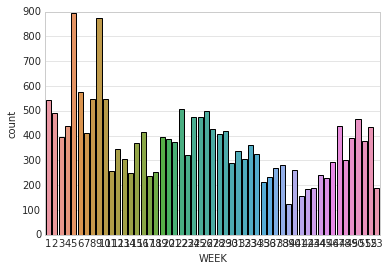

In [38]:
week_cancelCount = flight_df.groupby('WEEK').ID.count()
sns.countplot(flight_df['WEEK'])
plt.show()

Number of locations at diffrent months, their flights been canceled by 0.5 rate:  7605


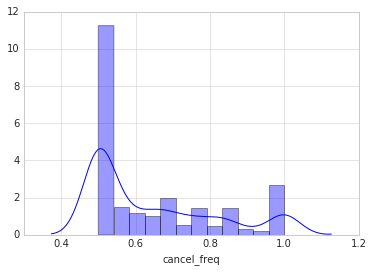

In [39]:
any_cancel = flight_df[['MONTH','WEEK','cancel_freq','county_avg_lat','county_avg_lon']][flight_df['cancel_freq'] > 0]
high_cancel = any_cancel[any_cancel['cancel_freq']>=0.5 ].sort_values('cancel_freq',ascending=False)
print "Number of locations at diffrent months, their flights been canceled by 0.5 rate: ",high_cancel.size
sns.distplot(high_cancel['cancel_freq'])


In [40]:
high_cancel.head()

,MONTH,WEEK,cancel_freq,county_avg_lat,county_avg_lon
19536,2,8,1.0,43.905643,-91.120572
14606,11,48,1.0,37.053793,-88.704328
17221,3,13,1.0,45.531429,-84.904533
19258,2,6,1.0,37.187443,-94.342492
19260,3,9,1.0,37.187443,-94.342492


In [41]:
any_cancel_lon = any_cancel['county_avg_lon']
any_cancel_lat = any_cancel['county_avg_lat']

In [42]:
high_cancel_lon = high_cancel['county_avg_lon']
high_cancel_lat = high_cancel['county_avg_lat']

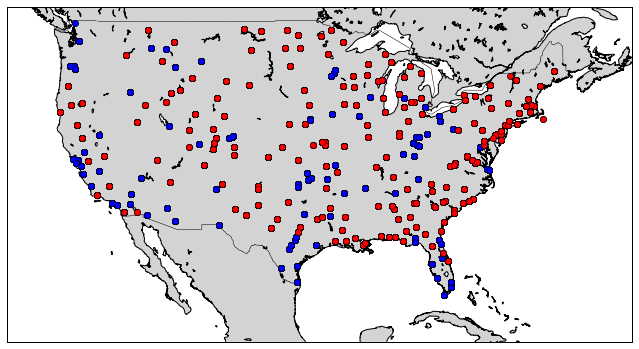

In [43]:
#The redpoints shows the areas with highest rates of flight cancelation 
#while blue dots shows all the flight cancelation due to bad weather condition
plt.figure(1)
# define Lambert Conformal basemap for North America.
plt.figure(figsize=(12,6))
map = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color='lightgray')
map.drawmapboundary()

#x,y = map(np.array(all_lon),np.array(all_lat))
#map.plot(x,y,'o',color='r')

#print len(june_lon),len(oct_lon),len(jan_lon)

#x,y = map(np.array(oct_lon),np.array(oct_lat))
#map.plot(x,y,'o',color='g')
x,y = map(np.array(any_cancel_lon),np.array(any_cancel_lat))
map.plot(x,y,'o',color='b')
x,y = map(np.array(high_cancel_lon),np.array(high_cancel_lat))
map.plot(x,y,'o',color='r')
#x,y = map(np.array(aug_lon),np.array(aug_lat))
#map.plot(x,y,'o',color='y')
plt.show()

In [44]:
flight_DC_JAN2016 = flight_df[(flight_df['MONTH'] == 1)  
                       & (flight_df['DEST_CITY_NAME'] == 'Washington, DC')]
print flight_DC_JAN2016[['cancel_freq','WEEK']]
print np.mean(flight_DC_JAN2016.cancel_freq)

      cancel_freq  WEEK
3655     0.003401     1
3656     0.025966     2
3657     0.006599     3
3658     0.033265     4
3659     0.025454     5
3705     0.096776     1
3706     0.077662     2
3707     0.022279     3
3708     0.227940     4
3709     0.067667     5
3760     0.095998     1
3761     0.070245     2
3762     0.019011     3
3763     0.213688     4
3764     0.104281     5
0.0726822875196


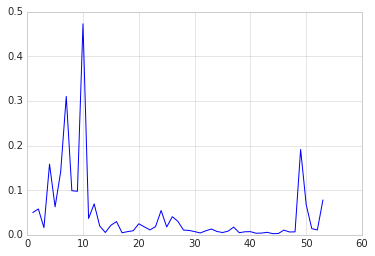

In [45]:
flight_DC_2016 = flight_df[(flight_df['DEST_CITY_NAME'] == 'Washington, DC')]

result = flight_DC_2016.groupby(['WEEK'],as_index=False).cancel_freq.mean()

#print result
plt.plot(result['WEEK'],result['cancel_freq'])


In [46]:
def show_accuracy(y_test, y_predict):

        fpr, tpr, thresh = roc_curve(y_test, y_predict)
        roc_auc = auc(fpr, tpr)
        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic',fontsize=20)
        plt.legend(loc="lower right")
        fig1 = plt.gcf()
        plt.show()
        [per, rec, f1, NoImp] = metrics.precision_recall_fscore_support(y_test, y_predict, average='macro')
        acc = metrics.accuracy_score(y_test, y_predict)
        print "Accuracy = %f percision = %f recall= %f F1_score= %f" % (acc, per, rec, f1)



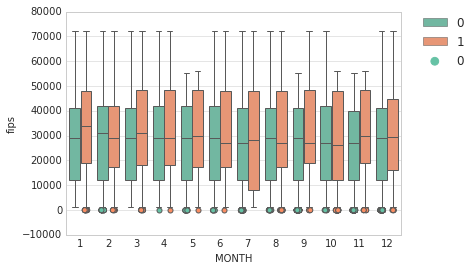

In [47]:

sns.stripplot(x="county_avg_lat", y="county_avg_lon", hue="y_label",
data=flight_df, jitter=True,
palette="Set2", split=True,linewidth=1,edgecolor='gray')

# Get the ax object to use later.
ax = sns.boxplot(x="MONTH", y="fips", hue="y_label",
data=flight_df,palette="Set2",fliersize=0)

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

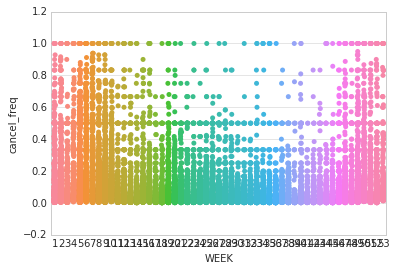

In [48]:
sns.set_style("whitegrid")
sns.stripplot(x="WEEK",y="cancel_freq",data=flight_df,jitter=True)

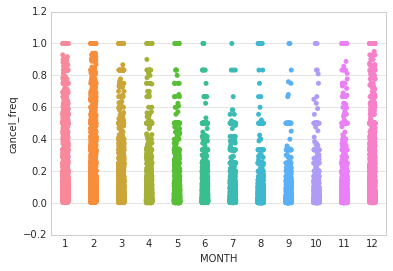

In [49]:
sns.set_style("whitegrid")

sns.stripplot(x="MONTH",y="cancel_freq",data=flight_df,jitter=True)

In [50]:
#Train Model
#THe whole range is C:-5 /15 , gamma:-15/3
######Zero_score Normalization
"""
from sklearn.model_selection import GridSearchCV
rbf_svm = svm.SVC()
C_range = np.logspace(5,10, 3)
gamma_range = np.logspace(-5, -3, 9)
param_grid = {'C': C_range,'gamma':gamma_range}
grid = GridSearchCV(rbf_svm, param_grid, verbose=1)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
BestC=grid.best_estimator_.C
bestGamma=grid.best_estimator_.gamma"""


bestC=pow(10,5)
bestG=pow(10,-3)
#print 'Train Linear SVM'
#clf_linear = svm.LinearSVC(C=bestC,class_weight={0:1,1:3})
#clf_linear.fit(X, y_label) 
#print 'Train RBF SVM'
#clf = svm.SVC(C=bestC, kernel='rbf',gamma=bestG,class_weight={0:1,1:3})
#clf.fit(X, y_label) 
#clf = svm.SVC(C=bestC, kernel='linear',class_weight={0:1,1:3})
print 'Train Random Forest Classifier'
clf_rfc= RandomForestClassifier(n_estimators = 100,random_state=0)
clf_rfc.fit(X, y_label)
print clf_rfc.feature_importances_


Train Random Forest Classifier
[ 0.23775062  0.38690765  0.37534173]


In [51]:
### To test

year = 2016

sql_query = """
    select * 
    from city_fips_table;
    """

city_fips_df = pd.read_sql_query(sql_query,con)


print '-----------processing year=%d'%year
flight_df= change_day_week(year) 
print flight_df.head()
flight_df = flight_df.groupby(['MONTH','WEEK','DEST_CITY_NAME'],as_index=False).normalized_cancel_dest.mean()
flight_df['cancel_freq']= flight_df['normalized_cancel_dest']
flight_df = flight_df.drop('normalized_cancel_dest',1)


####it is enough to group by just the city name since the name includes state as well
flight_df = flight_df.drop_duplicates()
flight_df["DEST_CITY"] = flight_df["DEST_CITY_NAME"].str.split(',').str[0].str.strip()
flight_df["STATE_AB"] = flight_df["DEST_CITY_NAME"].str.split(',').str[1].str.strip()

#print '---------------------- print merge ----------------------'
flight_df = pd.merge(flight_df,city_fips_df,left_on=["DEST_CITY",'STATE_AB'], right_on=['city','STATE_AB'], how='inner')

#print '---------------------- End merge ----------------------'
[thr,features,y_label_test,flight_df] = linked_lat_lon(flight_df,train_threshold)
#print flight_df[["MONTH",'county_avg_lat','county_avg_lon']]
X_test = features.values
#print X_test



-----------processing year=2016
(163680, 6)
   DAY_OF_MONTH  MONTH    FL_DATE                  DEST_CITY_NAME  \
0            17      1 2013-01-17                    Columbia, SC   
1            17      1 2013-01-17                     Houston, TX   
2            17      1 2013-01-17                     Atlanta, GA   
3            17      1 2013-01-17  West Palm Beach/Palm Beach, FL   
4            17      1 2013-01-17                     Atlanta, GA   

   DEST_STATE_FIPS  normalized_cancel_dest  WEEK  
0               45                0.052632     3  
1               48                0.002894     3  
2               13                0.028105     3  
3               12                0.014493     3  
4               13                0.028105     3  
----------------------label dataset-----------
threshold = 0.142857
number of flights canceled 4264
number of flights not canceled 8105


--------Random Forest-----
               precision    recall  f1-score   support

Not Cancelled       0.93      0.99      0.96      8105
    Cancelled       0.97      0.87      0.92      4264

  avg / total       0.95      0.94      0.94     12369



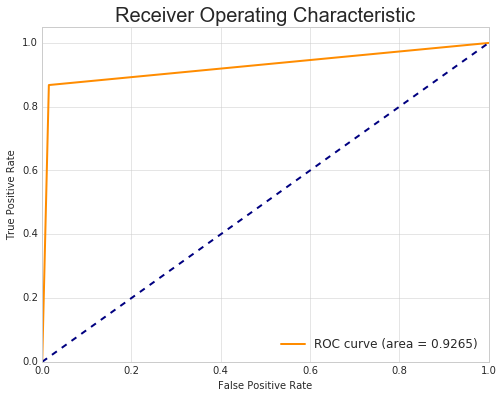

Accuracy = 0.944700 percision = 0.951235 recall= 0.926518 F1_score= 0.937167


In [52]:
# show Classification results
#print '--------Linear SVM-----'
#y_predict_lin=clf_linear.predict(X_test)
#print classification_report(y_label_test,y_predict_lin,target_names = ['Not Cancelled','Cancelled'])
#show_accuracy(y_label_test, y_predict_lin)


#print '--------RBF SVM-----'
#y_predict=clf.predict(X_test)
#print classification_report(y_label_test,y_predict,target_names = ['Not Cancelled','Cancelled'])
#show_accuracy(y_label_test, y_predict)

print '--------Random Forest-----'
y_predict_rfc=clf_rfc.predict(X_test)
print classification_report(y_label_test,y_predict_rfc,target_names = ['Not Cancelled','Cancelled'])
show_accuracy(y_label_test, y_predict_rfc)

In [54]:
##### RUN THIS TO SAVE YOUR MODEL
#random.seed(123)
#### Train your model on whole dataset
print 'start--------------------'
sql_query = """
    select * 
    from city_fips_table;
    """

city_fips_df = pd.read_sql_query(sql_query,con)
####it is enough to group by just the city name since the name includes state as well
flight_df_list=[]

for year in range(2013,2017):
    print '-----------processing year=%d'%year
    flight_df= change_day_week(year) 
    flight_df = flight_df.groupby(['MONTH','WEEK','DEST_CITY_NAME'],as_index=False).normalized_cancel_dest.mean()
    flight_df['cancel_freq']= flight_df['normalized_cancel_dest']
    flight_df = flight_df.drop('normalized_cancel_dest',1)

    flight_df_list.append(flight_df)
    
print 'concating the flights'   
flight_df = pd.concat(flight_df_list,axis=0)

flight_df = flight_df.drop_duplicates()
flight_df["DEST_CITY"] = flight_df["DEST_CITY_NAME"].str.split(',').str[0].str.strip()
flight_df["STATE_AB"] = flight_df["DEST_CITY_NAME"].str.split(',').str[1].str.strip()

print '---------------------- merge with city-fips----------------------'
flight_df = pd.merge(flight_df,city_fips_df,left_on=["DEST_CITY",'STATE_AB'], right_on=['city','STATE_AB'], how='inner')

print '---------------------- End merge ----------------------'
[t,features,y_label,flight_df] = linked_lat_lon(flight_df,0)
#print flight_df[["MONTH",'county_avg_lat','county_avg_lon']]
print features.isnull().sum()
print features.head()
X = features.values

######Zero_score Normalization
#X = preprocessing.scale(X)
#scaler = StandardScaler()
#scaler.fit(X)
#X =scaler.transform(X)
#bestC =pow(10,5)
#bestG=pow(10,-3)
#clf = svm.SVC(C=bestC, kernel='rbf',gamma=bestG,class_weight={0:1,1:3})
#clf.fit(X, y_label)
#joblib.dump(clf, 'flight_svmmodel.pkl')

clf= RandomForestClassifier(n_estimators = 100,random_state=0)
clf.fit(X, y_label)
joblib.dump(clf, 'flight_rfcmodel.pkl')

start--------------------
-----------processing year=2013
(34920, 6)
-----------processing year=2014
(90706, 6)
-----------processing year=2015
(134119, 6)
-----------processing year=2016
(163680, 6)
concating the flights
---------------------- merge with city-fips----------------------
---------------------- End merge ----------------------
----------------------label dataset-----------
threshold = 0.142857
number of flights canceled 6340
number of flights not canceled 18465
WEEK              0
county_avg_lat    0
county_avg_lon    0
dtype: int64
   WEEK  county_avg_lat  county_avg_lon
0     1       42.808838      -78.790872
1     2       42.808838      -78.790872
2     3       42.808838      -78.790872
3     4       42.808838      -78.790872
4     5       42.808838      -78.790872


['flight_rfcmodel.pkl']